In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
from model import DenseNet121

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
data_path = 'crops'

In [4]:
def read_data(path):
    data = []
    # cd into dataset path
    os.chdir(path)
    for img in os.listdir("."):
        cls_name = img.split(".")[0].split('_')[0]
        data.append([img, cls_name])
    os.chdir("..") # quit path
    df = pd.DataFrame(data, columns = ['image','class'])
    return df

In [5]:
data = read_data(data_path)
data.head()

,image,class
0,Black-grass_0.png,Black-grass
1,Black-grass_1.png,Black-grass
2,Black-grass_2.png,Black-grass
3,Black-grass_3.png,Black-grass
4,Black-grass_4.png,Black-grass


In [6]:
def pie_chart(df):
    plt.figure(figsize = (8,7))
    cls_count = df["class"].value_counts()
    explode = [0.1 for count in range(len(cls_count))]
    plt.pie(cls_count, labels = cls_count.index, shadow = True, 
          explode = explode, autopct='%1.1f%%')
    plt.title("dataset")
    plt.show()

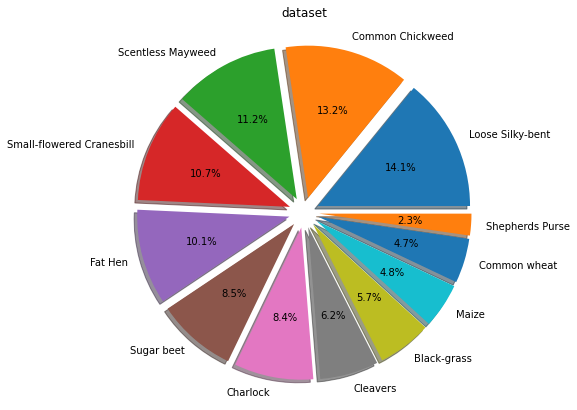

In [7]:
pie_chart(data)

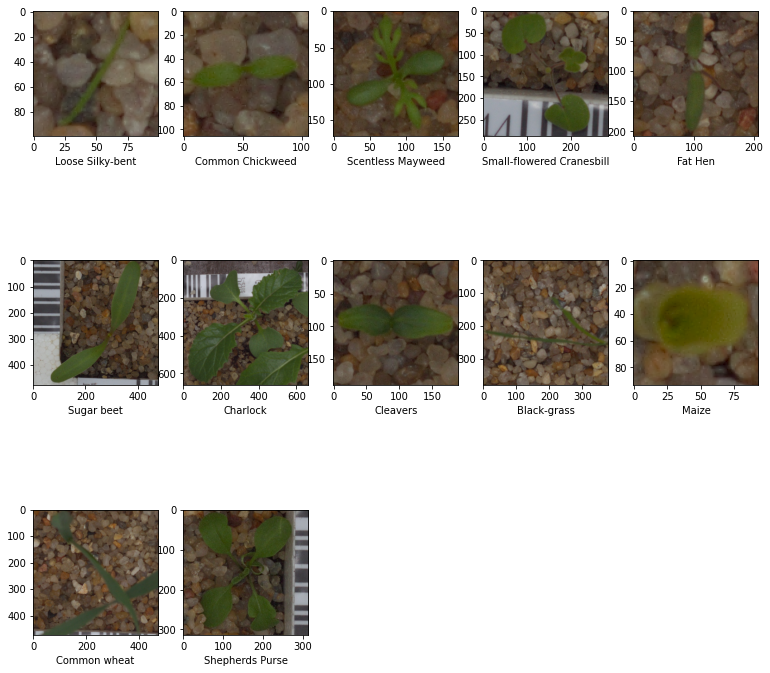

In [8]:
plt.figure(figsize = (13,13))
# visualization on first dataset
cls_count = data["class"].value_counts()
for index,cls in enumerate(cls_count.index):
    plt.subplot(3,5,index+1)
    filename = data[data["class"] == cls].iloc[0][0]
    img = cv2.imread(os.path.join(data_path, filename))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(cls)
    plt.imshow(rgb)

In [9]:
# train test valid split for dataset 1
train_data, test_data = train_test_split(data, test_size = 0.1, random_state = 10)

train_data, valid_data = train_test_split(train_data, test_size = 0.1, random_state = 20)

In [10]:
dataaug_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
dataaug_generator = dataaug_datagen.flow_from_dataframe(
    dataframe = train_data.sample(n=1),
    directory = data_path,
    x_col = 'image',
    y_col = 'class',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = 1
)

Found 1 validated image filenames belonging to 1 classes.


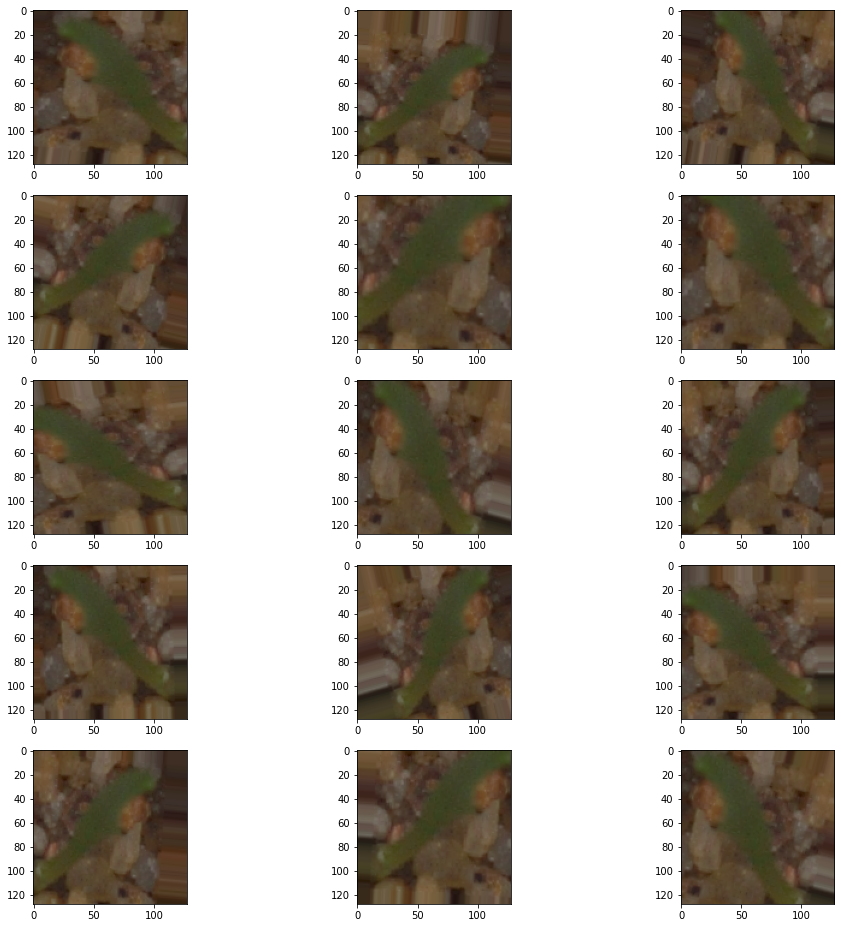

In [11]:
# visualize on augmented data
plt.figure(figsize = (15,13))
for x in range(0,15):
    plt.subplot(5,3,x+1)
    for x_batch,y_batch in dataaug_generator:
        plt.imshow(x_batch[0])
        break
plt.tight_layout()
plt.show()

In [12]:
filename = "dense.h5"

early_stop = EarlyStopping(monitor = 'val_loss',mode = 'min',
                            patience = 8,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

checkpoints = ModelCheckpoint(filename, verbose=1, save_best_only=True, period=1)

callbacks = [early_stop, learning_rate_reduction, checkpoints]

In [13]:
class BalancedDataGenerator(Sequence):
    def __init__(self, data, data_path, shuffle, cls, img_size, batch_size=32):
        self.datagen = self.datagen_generator()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.data_path = data_path
        self.x = data[["image"]]
        self.y = data["class"]
        self.cls = cls
        # initialize balance generator
        self.gen, self.steps_per_epoch = balanced_batch_generator(self.x, self.y, 
                                                                  sampler=RandomOverSampler(),
                                                                  batch_size=self.batch_size)
        
    def datagen_generator(self):
        datagen = ImageDataGenerator(
                    rotation_range=15,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                )
        return datagen
        
    def __len__(self):
        return self.steps_per_epoch
    
    def __data_generation(self, x, y):
        data = pd.DataFrame(x, columns = ['image'])
        data["class"] = y.iloc[:]
        data.reset_index(inplace = True, drop = True)
        return data

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        df = self.__data_generation(x_batch, y_batch)
        return self.datagen.flow_from_dataframe(dataframe = df, 
                                                directory = self.data_path,
                                                x_col = 'image',
                                                y_col = 'class',
                                                target_size = self.img_size,
                                                class_mode = 'categorical',
                                                shuffle = self.shuffle,
                                                classes = self.cls,
                                                batch_size = self.batch_size).next()


In [14]:
def read_class_name(df):
    classes_count = df["class"].value_counts()
    classes_name = list(classes_count.index)
    return classes_name

In [15]:
img_size = (128,128,3)
batch_size = 32

# both dataset classes
classes = read_class_name(data)

# dataset 1 generator
train_generator = BalancedDataGenerator(train_data, data_path = data_path, shuffle = True, 
                                           cls = classes,
                                           img_size = img_size[:2], 
                                           batch_size = batch_size)
val_generator = BalancedDataGenerator(valid_data, data_path = data_path, shuffle = True,
                                         cls = classes,
                                         img_size = img_size[:2],
                                         batch_size = batch_size)


In [16]:
# build model
DN = DenseNet121(input_shape = img_size, n_cls = len(classes))
model = DN.build_model()
print(model.summary())

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [17]:
epochs = 25

history = model.fit_generator(
          generator = train_generator, 
          validation_data = val_generator,
          steps_per_epoch = len(train_data)//batch_size,
          epochs = epochs,
          callbacks = callbacks
        )

Streaming output truncated to the last 5000 lines.
253/253 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8973Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 24 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image filenames belonging to 12 classes.
Found 32 validated image 

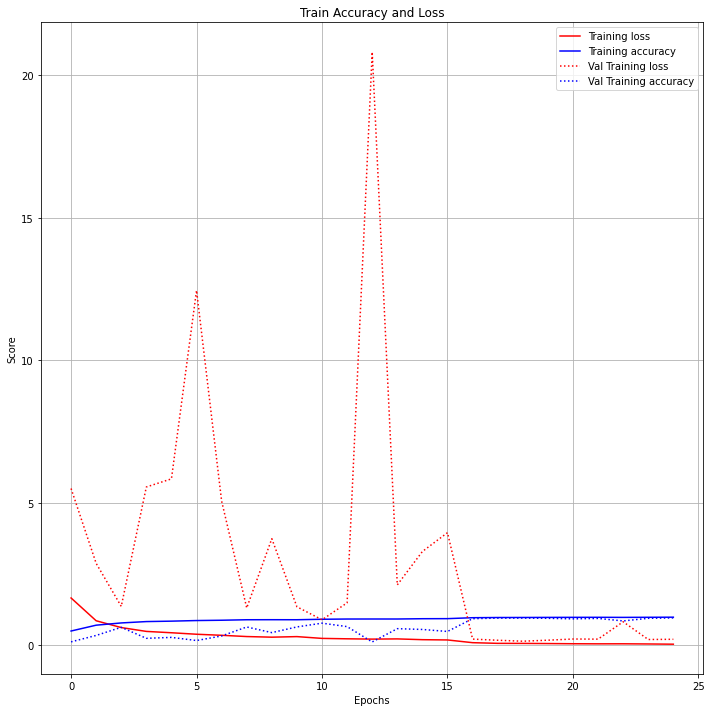

In [18]:
fig,ax1 = plt.subplots(1,1,figsize=(10,10))
# loss and accuracy
ax1.plot(history.history['loss'], color = 'r', label='Training loss')
ax1.plot(history.history['accuracy'],color='b',label='Training accuracy')
ax1.plot(history.history['val_loss'], color='r', linestyle = 'dotted', label='Val Training loss')
ax1.plot(history.history['val_accuracy'],color='b', linestyle = 'dotted', label='Val Training accuracy')
ax1.set_title("Train Accuracy and Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Score")

ax1.grid(True)
plt.tight_layout()
ax1.legend()
plt.show()

In [19]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = data_path,
    x_col = 'image',
    y_col = 'class',
    target_size = img_size[:2],
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size
)

Found 1002 validated image filenames belonging to 12 classes.


In [20]:
def rebuild_model(weights, input_shape, classes):
    DN = DenseNet121(input_shape = input_shape, n_cls = len(classes))
    model = DN.build_model()
    model.load_weights(weights)
    return model

In [21]:
# rebuild model
re_model = rebuild_model("dense.h5", img_size, classes)

In [22]:
def prediction(model, test_generator, classes):
    result = model.predict_generator(test_generator)
    y_pred = np.argmax(result, axis = 1)
    y_true = np.array(test_generator.classes)
    metric_analyzer(y_pred, y_true)
    return y_pred, y_true

def metric_analyzer(y_pred, y_true):
    report = classification_report(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    print(report)
    
    #visualization
    fontsize = 18
    matrix_df = matrix
    plt.figure(figsize = (12,12))
    sns.heatmap(matrix_df, annot = True, fmt = "d")
    plt.xlabel('predicted', fontsize = fontsize)
    plt.ylabel('truth', fontsize = fontsize)

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        64
           1       1.00      1.00      1.00       102
           2       1.00      1.00      1.00        66
           3       1.00      0.99      1.00       128
           4       1.00      0.97      0.98        60
           5       1.00      1.00      1.00       107
           6       0.97      0.81      0.88       140
           7       0.98      1.00      0.99        40
           8       0.99      1.00      1.00       106
           9       0.95      1.00      0.98        20
          10       1.00      1.00      1.00        95
          11       0.99      0.99      0.99        74

    accuracy                           0.97      1002
   macro avg       0.96      0.98      0.97      1002
weighted avg       0.97      0.97      0.97      1002



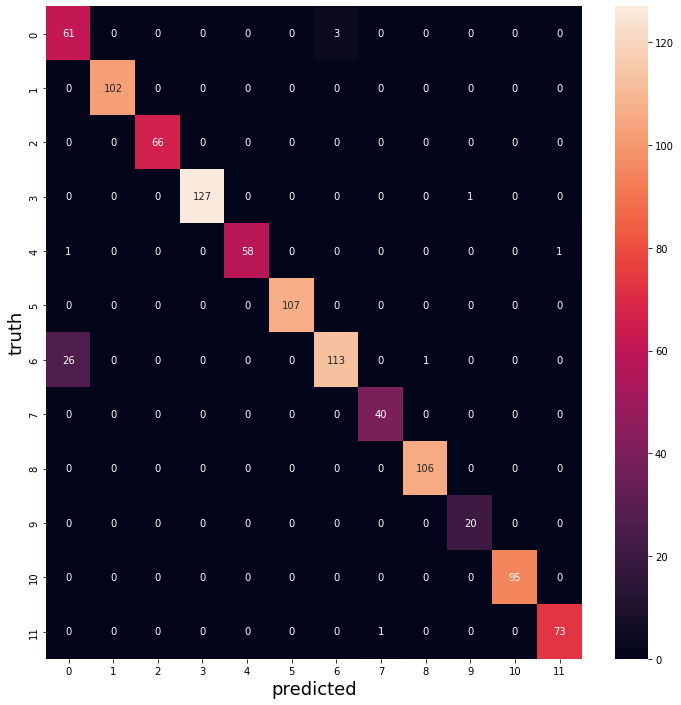

In [23]:
y_pred, y_true = prediction(model, test_generator, classes)

In [49]:
def visualization(test_df, data_path, result, test_generator):
    count = 8
    images = test_df[:count]
    class_indices = [name for name, cls in test_generator.class_indices.items()]
    pred_class = [class_indices[index] for index in result[:count]]
    plt.figure(figsize=(20,14))
    for x in range(count):
        plt.subplot(2,4,x+1)
        img = cv2.imread(os.path.join(data_path, str(images.iloc[x][0])))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.xlabel("Predict:{}".format(pred_class[x]), fontsize = 18)
        plt.imshow(img)

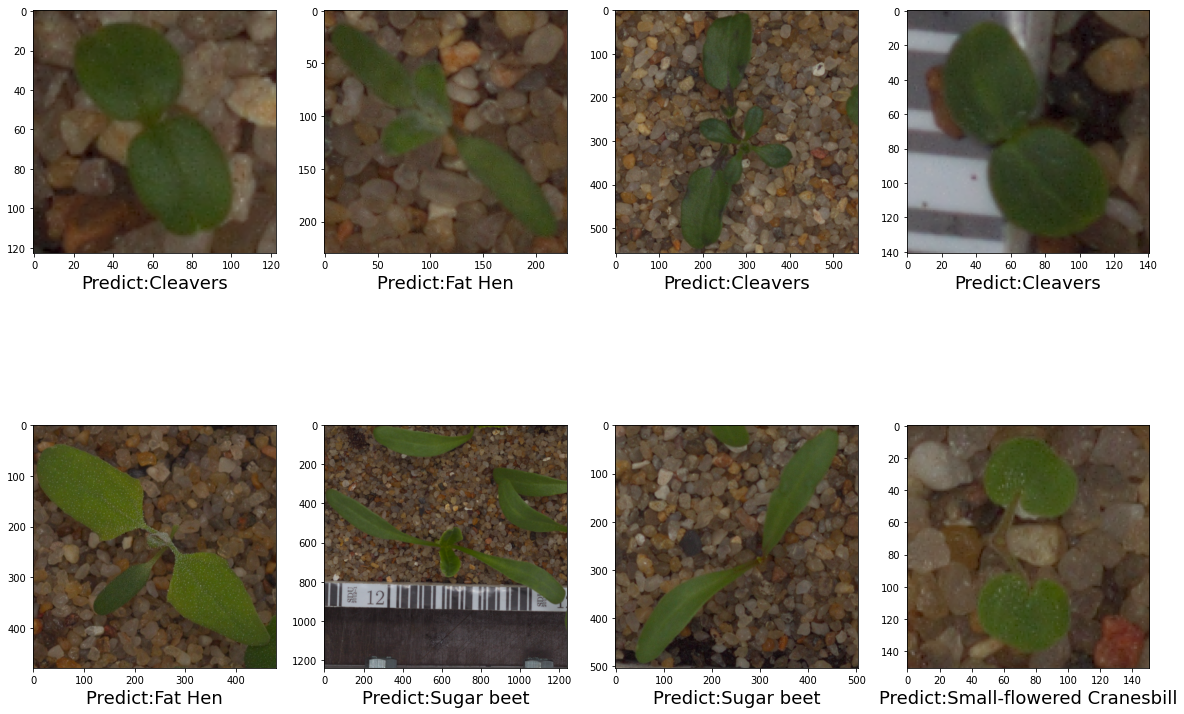

In [51]:
visualization(test_data, data_path, y_pred, test_generator)